# Weight  of evidence

Weight of Evidence (WoE) was developed primarily for the credit and financial industries to help build more predictive models to evaluate the risk of loan default. That is, to predict how likely the money lent to a person or institution is to be lost. Thus, the Weight of Evidence is a measure of the "strength” of a grouping technique to separate good and bad risk (default). 

- WoE will be 0 if the P(Goods) / P(Bads) = 1, that is if the outcome is random for that group.
- If P(Bads) > P(Goods) WoE will be < 1 and.
- If P(Goods) > P(Bads), WoE will be < 0.

### Advantages:
- It creates a monotonic relationship between the target and the independent variables.
- It orders the categories on a "logistic" scale which is natural for logistic regression.
- The transformed variables can then be compared because they are on the same scale. Therefore, it is possible to determine which one is more predictive.

### Limitation:
- Prone to cause over-fitting

### Dataset:
- Titanic dataset


### Content:

1. First Steps.
2. Explore Original Relationship between Categorical Variables and Target.
3. Mean Encoding with Pandas.
4. Inspect the Newly Created Monotonic Relationship.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## 1. First Steps

In [2]:
# load dataset

data = pd.read_csv(
    '../titanic.csv',
    usecols=['cabin', 'sex', 'embarked', 'survived'])

data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [3]:
# remove observations with na in embarked

data.dropna(subset=['embarked'], inplace=True)
data.shape

(1307, 4)

In [4]:
# extract the first letter of the cabin
# to create a simpler variable

data['cabin'] = data['cabin'].astype(str).str[0]

In [5]:
# the observations where cabin = T
# because only few observations show T in the dataset

data = data[data['cabin']!= 'T']
data.shape

(1306, 4)

In [6]:
# how many labels each variable has

for col in data.columns:
    print(col, ': ', len(data[col].unique()), ' labels')

survived :  2  labels
sex :  2  labels
cabin :  8  labels
embarked :  3  labels


In [7]:
# explore the unique categories
data['cabin'].unique()

array(['B', 'C', 'E', 'D', 'A', 'n', 'F', 'G'], dtype=object)

In [8]:
data['sex'].unique()

array(['female', 'male'], dtype=object)

In [9]:
data['embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

First, calculate the WoE using the train set, and then use those for mappings in the test set.

It is needed to keep the target within the training set.

In [10]:
# separate into training and testing set.
# here, the target is kept in the train ds-s as well!!

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked', 'survived']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((914, 4), (392, 4))

## 2. Explore Original Relationship between Categorical Variables and Target

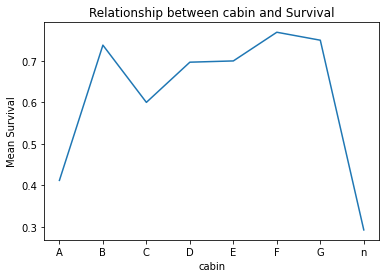

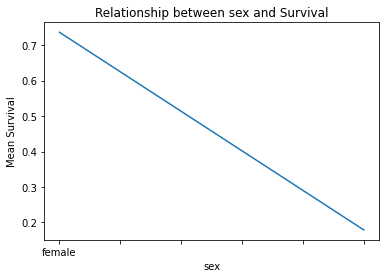

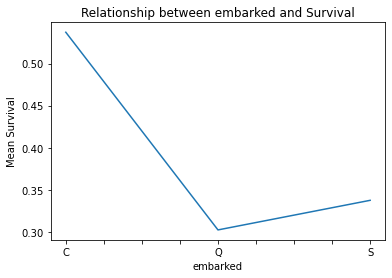

In [11]:
# explore the relationship of the categories with the target

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survival')
    plt.show()

The relationship between the target and the categories of the categorical variables goes up and down, depending on the category.


## 3. Weight of Evidence with pandas

- returns pandas dataframe
<br>but
- it does not preserve information from train data to propagate to test data

It is needed to store the encoding maps separately if planning to use them in production.

In [12]:
# with functions

def find_category_mappings(df, variable, target):

    # copy of the original dataframe to not accidentally modify it
    tmp = df.copy()

    # total positive class
    total_pos = df[target].sum()

    # total negative class
    total_neg = len(df) - df[target].sum()

    # non target
    tmp['non-target'] = 1 - tmp[target]

    # % of positive class per category, respect to total positive class
    pos_perc = tmp.groupby([variable])[target].sum() / total_pos

    # % of negative class per category, respect to total negative class
    neg_perc = tmp.groupby([variable])['non-target'].sum() / total_neg

    # concatenate
    prob_tmp = pd.concat([pos_perc, neg_perc], axis=1)

    # calculate the Weight of Evidence
    prob_tmp['woe'] = np.log(prob_tmp[target]/prob_tmp['non-target'])

    return prob_tmp['woe'].to_dict()


def integer_encode(train, test, variable, ordinal_mapping):

    train[variable] = train[variable].map(ordinal_mapping)

    test[variable] = test[variable].map(ordinal_mapping)

In [13]:
# loop over the remaining categorical variables

for variable in ['cabin', 'sex', 'embarked']:

    mappings = find_category_mappings(X_train, variable, 'survived')

    integer_encode(X_train, X_test, variable, mappings)

In [14]:
# the result

X_train.head()

,cabin,sex,embarked,survived
843,-0.375071,-1.013111,-0.164796,0
869,-0.375071,-1.013111,-0.164796,0
430,-0.375071,1.535068,-0.164796,1
481,-0.375071,1.535068,0.658871,1
1308,-0.375071,-1.013111,-0.164796,0


## 4. Inspect the Newly Created Monotonic Relationship

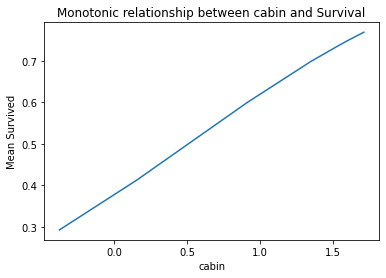

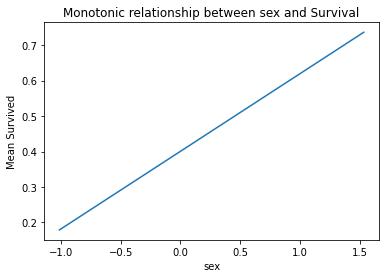

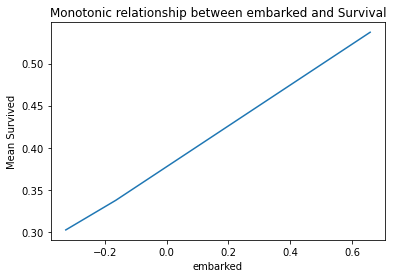

In [15]:
# in the train set
for var in ['cabin', 'sex', 'embarked']:

    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Monotonic relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survived')
    plt.show()

Note the monotonic relationships between the mean target and the categories in the train set.

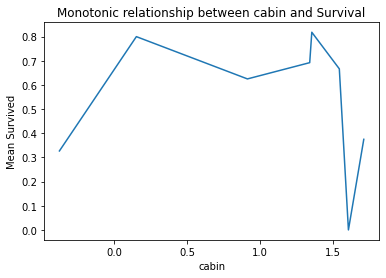

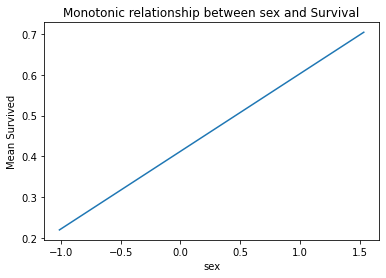

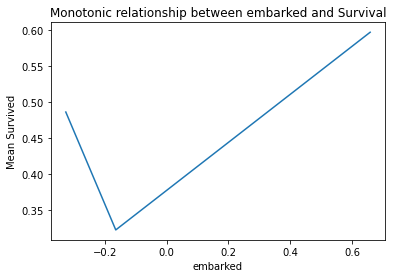

In [16]:
# now in the test set
for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_test.groupby([var])['survived'].mean().plot()
    fig.set_title('Monotonic relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survived')
    plt.show()

The monotonic relationship does not hold when encoding the categorical variables in the test set. This could mean that the categories are not informative of the target or the proportion of survivors is not homogeneous between the categories in the train and test sets. 

In situations like this, it could be better to try grouping rare labels into a joint category as we will cover later in this section, before applying the Weight of evidence transformation.